In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [70]:
import torch
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import cosine

In [5]:
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [7]:
num_objects = 1
noisy=False
weight_decay = 0.0004
encoder_model='small7'

In [8]:
def get_log_folder(dataset,weight_decay,encoder_model):
    if weight_decay == 0.0004 and encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint/joint"
    elif weight_decay == 0.0004:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}/joint"
    elif encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint_wd_{weight_decay}/joint"
    else:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}_wd_{weight_decay}/joint"
    return log_folder

In [9]:
dataset_name = "synthetic_{}".format(num_objects)
if noisy:
    dataset_name += "_noisy"

data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)

In [10]:
if num_objects == 2:
    concept_combinations = [
        [1,0,1,0],
        [0,1,0,1],
        [1,0,0,1],
        [0,1,1,0],
    ]
    concept_y = [
        0,1,1,1
    ]
else:
    concept_combinations = []
    concept_y = []
    for i in range(128):
        is_triangle = [random.randint(0,1) for j in range(num_objects)]
        is_square = [1-j for j in is_triangle]
        
        attribute_label = [elem for pair in zip(is_triangle, is_square) for elem in pair]
        concept_combinations.append(attribute_label)
        
        task_y = int(sum(is_square)<num_objects//2)
        concept_y.append(task_y)

In [11]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = train_data_path.replace('train.pkl','extra.pkl')

In [12]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [13]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [14]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

## Plot the Dataset

In [15]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))

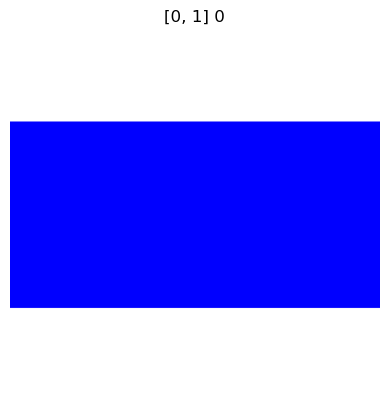

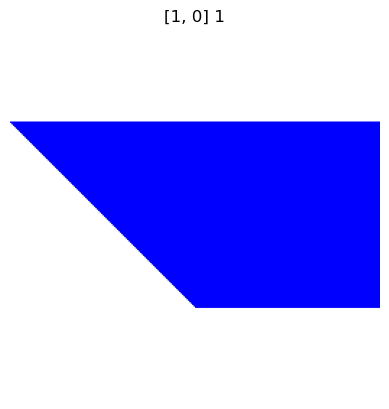

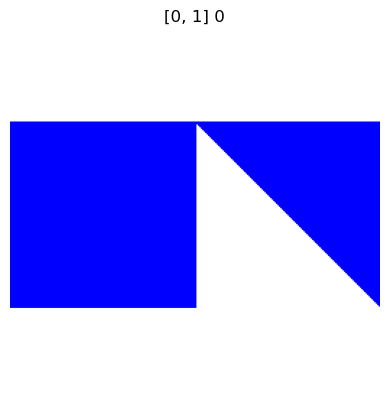

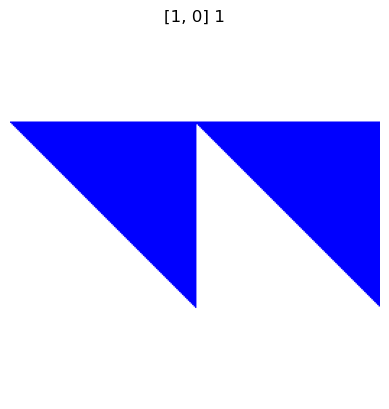

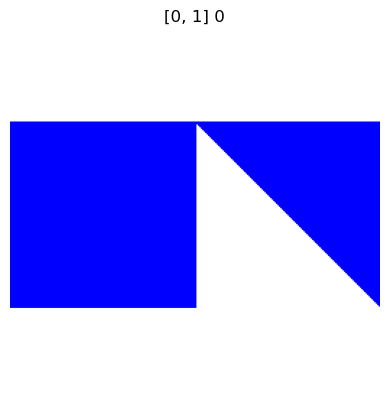

In [16]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 
    plt.title(str(train_pkl[i]['attribute_label']) + ' '+str(train_pkl[i]['class_label']))

## Analyze Concept-Task Relationships

In [17]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

## Analyze Concept-Input Relationships

### Maximal Activation

In [18]:
def valid_image(image):
    """
    Transform an image so it matches training data patterns
    
    Arguments:
        image: PyTorch Tensor of size (3,256,256)
        
    Returns: PyTorch Tensor of size (3,256,256)
    """
        
    image[:,:,:128] = 0.25
    return image


In [19]:
def valid_image_bounding_box(image,bounding_box):
    """Makes sure image is only within some bounding box
    
    Arguments:
        image: PyTorch Tensor
        bounding_box: 2D List of Lists with 4 elements (2x2) 
            The first 2 elements define the y_0 and y_1 of the bounding box
            The second 2 elements define the x_0 and x_1 

    Returns: PyTorch Tensor
    """

    image[:,:bounding_box[0][0],:] = 0.25
    image[:,bounding_box[0][1]:,:] = 0.25
    image[:,:,:bounding_box[1][0]] = 0.25
    image[:,:,bounding_box[1][1]:] = 0.25

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.],
        [0.]], grad_fn=<SigmoidBackward0>)


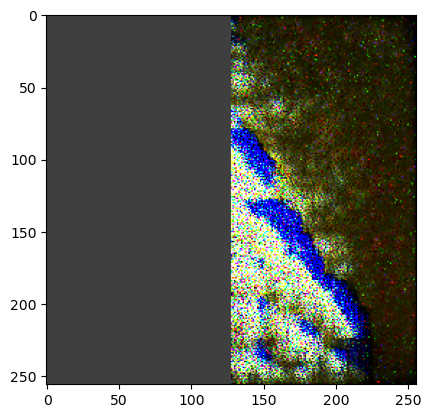

In [20]:
ret_image_left = get_maximal_activation(joint_model,run_joint_model,0,valid_image,lamb=1)
print(torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_left)[1]))
plt.imshow(ret_image_left.detach()[0].numpy().transpose((1,2,0)))

In [21]:
no_color = torch.Tensor([0.25,0.25,0.25])
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_left)[1])

tensor([[1.],
        [0.]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.],
        [0.]], grad_fn=<SigmoidBackward0>)


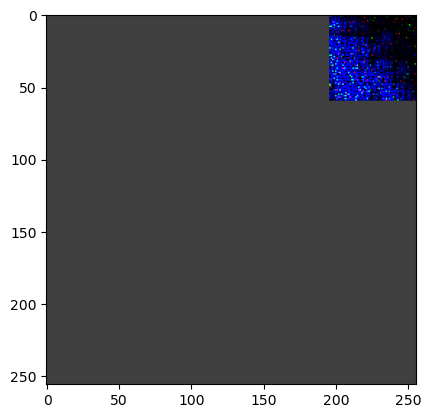

In [22]:
def new_valid_image(image):
    image[:,:,:196] = 0.25
    image[:,-196:,:] = 0.25
    return image

ret_image_left = get_maximal_activation(joint_model,run_joint_model,1,new_valid_image,lamb=1)
print(torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_left)[1]))
plt.imshow(ret_image_left.detach()[0].numpy().transpose((1,2,0)))

In [23]:
if num_objects > 1:
    ret_image = get_maximal_activation(joint_model,run_joint_model,3,valid_right_image,lamb=1)
    print(torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1]))
    plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.],
        [0.]], grad_fn=<SigmoidBackward0>)


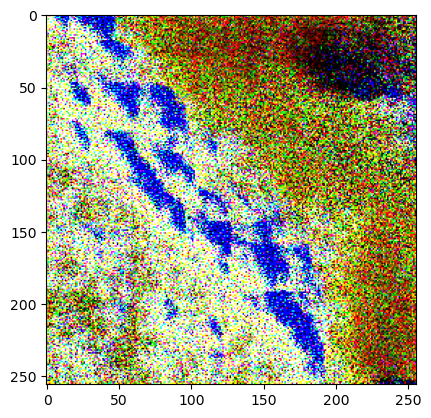

In [24]:
ret_image = get_maximal_activation(joint_model,run_joint_model,0,lambda img: img)
print(torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1]))
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

In [25]:
def binary_search_image(concept_num,num_steps):
    bounding_box = [[0,256],[128,256]]
    activations = []

    for i in range(num_steps):
        split_direction = i%2 

        midpoint = sum(bounding_box[split_direction])//2 
        bounding_box_1 = deepcopy(bounding_box)
        bounding_box_1[split_direction][0] = midpoint

        bounding_box_2 = deepcopy(bounding_box)
        bounding_box_2[split_direction][1] = midpoint 

        ret_image_1 = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                               lambda image: valid_image_bounding_box(image,bounding_box_1),lamb=1)
        
        ret_image_2 = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                               lambda image: valid_image_bounding_box(image,bounding_box_2),lamb=1)
        
        activation_1 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_1)[1])[concept_num][0].detach().numpy()
        activation_2 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_2)[1])[concept_num][0].detach().numpy()

        if activation_2 > activation_1: 
            bounding_box = bounding_box_2 
        else:
            bounding_box = bounding_box_1 

        ret_image_1 = ret_image_1.detach() 
        ret_image_2 = ret_image_2.detach() 

        activations.append(max(activation_1,activation_2))
        print("On step {}, bounding box {}, activations {}".format(i,bounding_box,activations))

    return activations, bounding_box     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[2.5738e-14],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


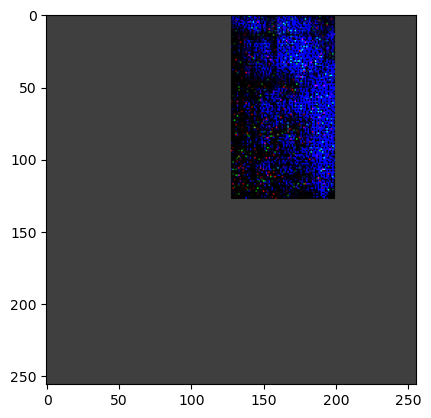

In [46]:
ret_image = get_maximal_activation(joint_model,run_joint_model,1,
                                               lambda image: valid_image_bounding_box(image,[[0,128],[128,200]]),lamb=1)
print(torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1]))
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

In [47]:
ret_image = ret_image.detach() 

In [60]:
ret_image_copy = deepcopy(ret_image)
ret_image_copy[0,:,:,128:135] = 0.25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.0000e+00],
        [1.7899e-15]], grad_fn=<SigmoidBackward0>)

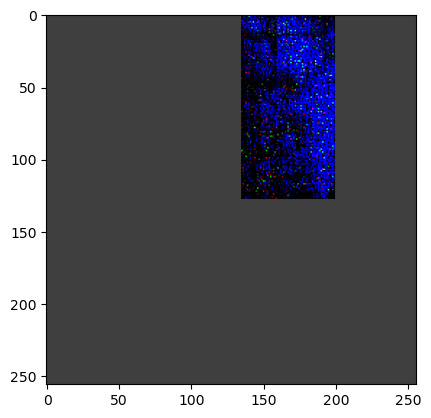

In [61]:
plt.imshow(ret_image_copy.detach()[0].numpy().transpose((1,2,0)))
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image_copy)[1])

## Compare Adversarial and Blank Images

In [62]:
blank_image = deepcopy(ret_image)
blank_image[:,:,:,:] = 0.25

In [63]:
adversarial_image = ret_image
near_adversarial = ret_image_copy 

In [65]:
run_joint_model(joint_model,blank_image)[1], run_joint_model(joint_model,adversarial_image)[1], run_joint_model(joint_model,near_adversarial)[1]

(tensor([[ 445.8741],
         [-454.1967]], grad_fn=<SqueezeBackward1>),
 tensor([[-31.2908],
         [ 16.5811]], grad_fn=<SqueezeBackward1>),
 tensor([[ 18.1332],
         [-33.9566]], grad_fn=<SqueezeBackward1>))

In [170]:
first_layer_blank = joint_model.first_model.conv1(blank_image)
first_layer_adversarial = joint_model.first_model.conv1(adversarial_image)

In [175]:
filter_norms = [np.linalg.norm((first_layer_blank[0][i]-first_layer_adversarial[0][i]).detach().numpy()) for i in range(first_layer_blank.shape[1])]

{'whiskers': [<matplotlib.lines.Line2D at 0x14d1fecc6910>,
 'caps': [<matplotlib.lines.Line2D at 0x14d1fec74dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d1fecc6790>],
 'medians': [<matplotlib.lines.Line2D at 0x14d1fec74090>],
 'fliers': [<matplotlib.lines.Line2D at 0x14d1fec74990>],
 'means': []}

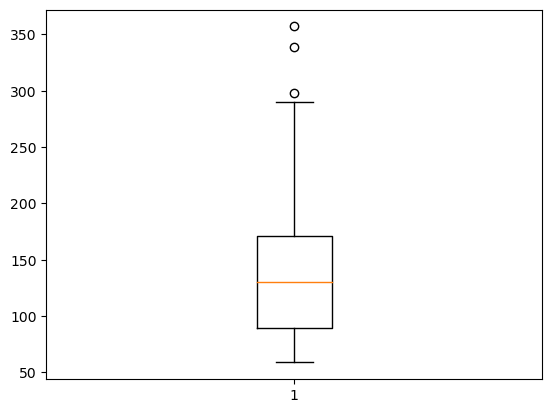

In [176]:
plt.boxplot(filter_norms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


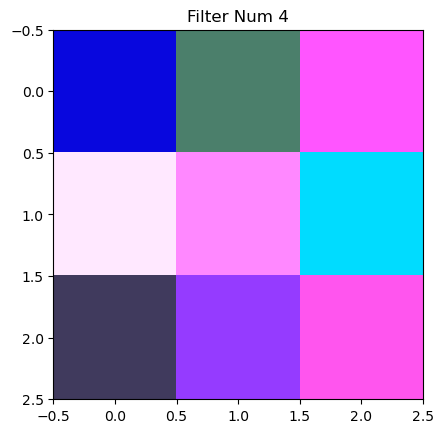

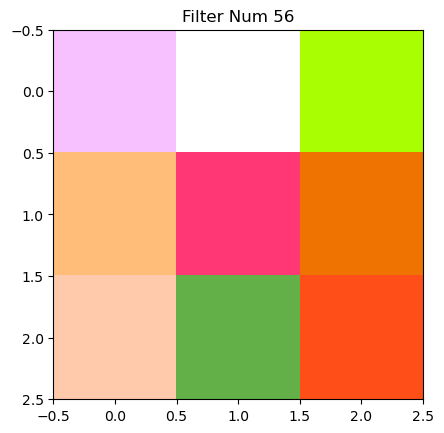

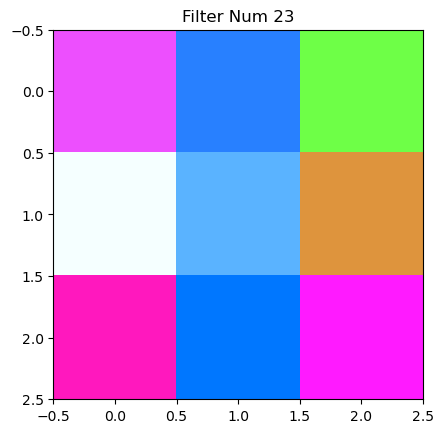

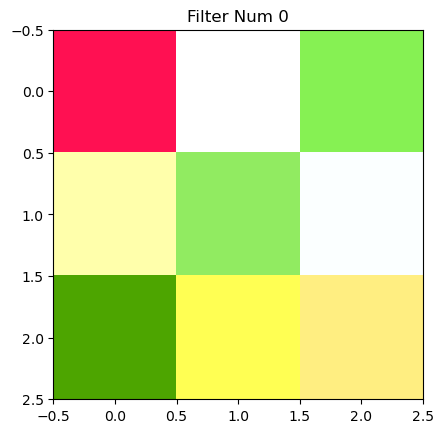

<Figure size 640x480 with 0 Axes>

In [189]:
sorted_filters = np.argsort(filter_norms)[::-1]
for filter_num in sorted_filters[:4]:
    plt.title("Filter Num {}".format(filter_num))
    normalized_filter = joint_model.first_model.conv1.weight[filter_num].detach().numpy()
    normalized_filter /= np.max(normalized_filter) 
    normalized_filter -= np.min(normalized_filter)
    plt.imshow(normalized_filter.transpose((1,2,0)))
    plt.figure() 

In [66]:
filter_activations_adversarial = get_last_filter_activations(joint_model,run_joint_model,adversarial_image,1)
filter_activations_blank = get_last_filter_activations(joint_model,run_joint_model,blank_image,1)
filter_activations_near_adversarial = get_last_filter_activations(joint_model,run_joint_model,near_adversarial,1)

In [68]:
np.mean(filter_activations_adversarial), np.mean(filter_activations_blank), np.mean(filter_activations_near_adversarial)

(0.008040346, -0.22183159, -0.016636245)

In [71]:
cosine(filter_activations_near_adversarial,filter_activations_adversarial)

0.0004348158836364746

In [79]:
sorted(np.abs(filter_activations_near_adversarial - filter_activations_adversarial),reverse=True)

[1.2834759,
 1.047245,
 0.80789185,
 0.7661619,
 0.7187538,
 0.6872902,
 0.66849995,
 0.6577349,
 0.65244293,
 0.65216875,
 0.5683212,
 0.52951574,
 0.5245867,
 0.4676895,
 0.46711826,
 0.43327808,
 0.430027,
 0.42445707,
 0.42165184,
 0.40739965,
 0.38600922,
 0.3823738,
 0.37834215,
 0.37807083,
 0.37604666,
 0.37553263,
 0.3740239,
 0.3565054,
 0.34931993,
 0.34420443,
 0.34203815,
 0.34148216,
 0.33429146,
 0.3260002,
 0.32236195,
 0.31985092,
 0.31803703,
 0.3090906,
 0.30436468,
 0.29950047,
 0.29788542,
 0.29197907,
 0.28772545,
 0.28699756,
 0.282171,
 0.28113413,
 0.2786746,
 0.2770853,
 0.2759428,
 0.27375448,
 0.2703328,
 0.2631731,
 0.2630005,
 0.25611162,
 0.2558596,
 0.25330842,
 0.25188732,
 0.24670649,
 0.24282265,
 0.24257088,
 0.24204111,
 0.23692131,
 0.23483896,
 0.23457885,
 0.23362827,
 0.22940922,
 0.22843146,
 0.22699308,
 0.22681236,
 0.22466207,
 0.22129536,
 0.21940613,
 0.21863282,
 0.2159195,
 0.2135973,
 0.21253991,
 0.21203232,
 0.20968771,
 0.2087512,
 0

In [72]:
cosine(filter_activations_adversarial,filter_activations_blank)

0.27113956212997437

In [73]:
cosine(filter_activations_near_adversarial,filter_activations_blank)

0.259016215801239

In [277]:
np.argsort(filter_activations_adversarial-filter_activations_blank)

array([ 148,  108,  208, ..., 1059, 1057, 1056])

## Hybrid Models

In [208]:
joint_model_7 = joint_model 

In [243]:
def run_k_layers(model,input,k):
    x = input 
    
    for i in range(k):
        x = model.first_model.pool(torch.relu(getattr(model.first_model,'conv{}'.format(i+1))(x)))

    return x

In [209]:
log_folder = get_log_folder(dataset_name,weight_decay,'small5')
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
joint_model_5 = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model_5.eval()


In [210]:
log_folder = get_log_folder(dataset_name,weight_decay,'small6')
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
joint_model_6 = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model_6.eval()


In [211]:
run_joint_model(joint_model_5,adversarial_image)

(tensor([[-2.1255,  1.2434]], grad_fn=<AddmmBackward0>),
 tensor([[ 257.9340],
         [-600.3975]], grad_fn=<SqueezeBackward1>))

In [212]:
run_joint_model(joint_model_6,adversarial_image)

(tensor([[-1.6631,  1.4078]], grad_fn=<AddmmBackward0>),
 tensor([[ 395.9543],
         [-378.7265]], grad_fn=<SqueezeBackward1>))

In [213]:
run_joint_model(joint_model_7,adversarial_image)

(tensor([[ 1.2177, -1.5527]], grad_fn=<AddmmBackward0>),
 tensor([[-641.0706],
         [ 630.7952]], grad_fn=<SqueezeBackward1>))

In [263]:
model_5_output = run_k_layers(joint_model_5,adversarial_image,5)
model_6_output = run_k_layers(joint_model_6,adversarial_image,5)
model_7_output = run_k_layers(joint_model_7,adversarial_image,5)

model_6_final_output = run_k_layers(joint_model_6,adversarial_image,6)

In [256]:
def run_from_k(model,x,start_k,max_k):
    for i in range(start_k,max_k+1):
        x = model.first_model.pool(torch.relu(getattr(model.first_model,'conv{}'.format(i))(x)))
    x = x.view(-1, model.first_model.conv_output_size)
    out = []
    for fc in model.first_model.all_fc:
        out.append(fc(x)) 
    return out 

In [260]:
run_from_k(joint_model_6,model_5_output,6,6)

[tensor([[290.7252]], grad_fn=<AddmmBackward0>),
 tensor([[-270.2855]], grad_fn=<AddmmBackward0>)]

In [265]:
run_from_k(joint_model_6,model_6_final_output,7,6)

[tensor([[395.9543]], grad_fn=<AddmmBackward0>),
 tensor([[-378.7265]], grad_fn=<AddmmBackward0>)]

In [266]:
run_from_k(joint_model_7,model_6_final_output,7,7)

[tensor([[-328.5618]], grad_fn=<AddmmBackward0>),
 tensor([[311.5363]], grad_fn=<AddmmBackward0>)]

In [257]:
run_from_k(joint_model_7,model_5_output,6,7)

[tensor([[-267.8680]], grad_fn=<AddmmBackward0>),
 tensor([[260.9561]], grad_fn=<AddmmBackward0>)]

In [258]:
run_from_k(joint_model_7,model_6_output,6,7)

[tensor([[-399.0927]], grad_fn=<AddmmBackward0>),
 tensor([[393.2759]], grad_fn=<AddmmBackward0>)]

In [259]:
run_from_k(joint_model_7,model_7_output,6,7)

[tensor([[-641.0706]], grad_fn=<AddmmBackward0>),
 tensor([[630.7952]], grad_fn=<AddmmBackward0>)]

## Using only one Filter

In [21]:
no_color = torch.Tensor([0.25,0.25,0.25])
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
activations_blank = get_last_filter_activations(joint_model,run_joint_model,torch.stack([blank_image]),0)
indices_blank = np.argsort(activations_blank)

In [22]:
idx_10 = [i for i,num in enumerate(val_c) if num[0] == 1][0]
idx_01 = [i for i,num in enumerate(val_c) if num[1] == 1][0]

In [23]:
activations_10 = get_last_filter_activations(joint_model,run_joint_model,val_images[idx_10:idx_10+1],0)
indices_10 = np.argsort(activations_10)

In [24]:
activations_01 = get_last_filter_activations(joint_model,run_joint_model,val_images[idx_01:idx_01+1],0)
# activations_1001 -= activations_blank
indices_01 = np.argsort(activations_01)

In [25]:
activations_adversarial = get_last_filter_activations(joint_model,run_joint_model,ret_image_left,0)
indices_adversarial = np.argsort(activations_adversarial)

### Analyze Common Filters

In [26]:
common_filters = (set(indices_10[-10:]).intersection(
    set(indices_01[-10:])).intersection(indices_adversarial[-10:]))
common_filters = list(common_filters)

In [27]:
get_last_filter_activations(joint_model,run_joint_model,ret_image_left,0)

array([ 9.7968994e-05, -1.5301252e-05,  4.5350487e-05, ...,
        1.0257023e-03,  1.3212739e-03, -1.0842875e-03], dtype=float32)

In [28]:
filter_activations = joint_model.first_model.last_conv_output[0]
filter_activations = filter_activations.detach().numpy()
filter_activations -= np.min(filter_activations)
filter_activations /= np.max(filter_activations)

In [29]:
def show_filter(num):
    resized_filter = cv2.resize(filter_activations[num],(val_images[0].shape[1],val_images[0].shape[2]))
    plt.figure()
    plt.imshow(resized_filter,cmap='gray')

In [30]:
for i in set(indices_01[-10:]).intersection(indices_10[-10:]):
    show_filter(i)

In [34]:
joint_model

End2EndModel(
  (first_model): SimpleConvNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (all_fc): ModuleList(
      (0): FC(
        (fc): Linear(in_features=262144, out_features=1, bias=True)
      )
      (1): FC(
        (fc): Linear(in_features=262144, out_features=1, bias=True)
      )
    )
    (AuxLogits): InceptionAux(
      (conv0): BasicConv2d(
        (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): BasicConv2d(
        (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=T

In [ ]:
for i in common_filters:
    print(i)
    show_filter(i)

In [ ]:
[activations_blank[i] for i in common_filters]

[]

In [ ]:
for i in common_filters:
    print(activations_10[i], activations_01[i], activations_adversarial[i])